In [1]:
# !pip install git+https://github.com/deamonpog/gsdmm.git
# !pip install wordcloud
# !pip install --upgrade gensim
# !pip install --upgrade s3fs
# !pip install --upgrade boto3
# !pip install --upgrade numexpr
# !pip install --upgrade pandas

In [2]:
import string
import re
import html
import json
import gzip
import datetime
import itertools
import glob
import numpy as np
import pandas as pd

from wordcloud import WordCloud

import matplotlib.pyplot as plt

In [3]:
import gensim
from gsdmm import MovieGroupProcess

In [4]:
import nltk

from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
nltk.download("omw-1.4")

# punctuation
nltk.download("punkt")

# pos tagging
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')

from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords 
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/ec2-user/nltk_data...
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# s3 specific libraries
import boto3
s3 = boto3.resource("s3")

import s3fs
s3fs = s3fs.S3FileSystem(anon=False)

# data is at s3://mips-main-tests/chathura_tests/cache2/*cache*.json.gzip

In [6]:
from time_keeper import TimeKeeper

In [7]:
english_stop_words = set(stopwords.words('english'))

In [8]:
data_files = glob.glob("./cache2_data/*cache*.json.gzip")
data_files.sort()
len(data_files)

29317

In [9]:
class Maybe:
    def __init__(self, json_object):
        self.json_object = json_object
        
    def field(self, field):
        if self.json_object is not None and type(self.json_object) is dict and field in self.json_object:
            return Maybe(self.json_object[field])
        return Maybe(None)
    
    def index(self, index):
        if self.json_object is not None and type(self.json_object) is list and index < len(self.json_object):
            return Maybe(self.json_object[index])
        return Maybe(None)
    
    def array(self, func=lambda m: m, as_type=list):
        if self.json_object is not None and type(self.json_object) is list:
            return as_type([func(obj) for obj in self.json_object])
        return []
    
    def value(self):
        return self.json_object

# get_maybe(get_maybe(tweet_json, "referenced_tweets"), "quoted")

In [20]:
def read_local_text_data_raw(file_path):
    with gzip.open(file_path, 'r') as fin:
        json_bytes = fin.read()
    json_str = json_bytes.decode('utf-8')
    data = json.loads(json_str)
    return data


def read_local_text_data_filtered(file_path):
    with gzip.open(file_path, 'r') as fin:
        json_bytes = fin.read()
    json_str = json_bytes.decode('utf-8')
    data = json.loads(json_str)
    return Maybe(data).field("data").value(), Maybe(data).field("includes").field("places").value()

In [21]:
np.random.seed(123)

In [22]:
def read_tweets_and_places(in_data_files):
    all_tweets = []
    all_places = []
    for data_file in in_data_files:
        tweets, places = read_local_text_data_filtered(data_file)
        if tweets is not None:
            all_tweets.extend(tweets)
        else:
            print(f"Tweets is None for {data_file}")
        if places is not None:
            all_places.extend(places)
    place_dict = {place["id"]: place["full_name"] for place in all_places}
    return all_tweets, place_dict

In [23]:
%%time
tweets, places = read_tweets_and_places(data_files)

Tweets is None for ./cache2_data/querylist_cache_50_403.json.gzip
CPU times: user 5min 34s, sys: 17.3 s, total: 5min 51s
Wall time: 21min 32s


In [24]:
# Should be equal to following
expected_all_fields = {  'attachments',
                         'author_id',
                         'conversation_id',
                         'created_at',
                         'edit_history_tweet_ids',
                         'entities',
                         'geo',
                         'id',
                         'in_reply_to_user_id',
                         'public_metrics',
                         'referenced_tweets',
                         'text',
                         'withheld'  }
possible_fields = set().union(*[set(tweet.keys()) for tweet in tweets])
print(possible_fields == expected_all_fields)
possible_fields

True


{'attachments',
 'author_id',
 'conversation_id',
 'created_at',
 'edit_history_tweet_ids',
 'entities',
 'geo',
 'id',
 'in_reply_to_user_id',
 'public_metrics',
 'referenced_tweets',
 'text',
 'withheld'}

In [25]:
expected_common_fields = {  'author_id',
                             'conversation_id',
                             'created_at',
                             'edit_history_tweet_ids',
                             'id',
                             'public_metrics',
                             'text'  }
common_fields = possible_fields.intersection(*[set(tweet.keys()) for tweet in tweets])
print(common_fields == expected_common_fields)
common_fields

True


{'author_id',
 'conversation_id',
 'created_at',
 'edit_history_tweet_ids',
 'id',
 'public_metrics',
 'text'}

In [26]:
column_names = ['id',
                'conversation_id',
                'edit_history_tweet_ids',
                'author_id',
                'created_at',
                'text',
                'impression_count',
                'like_count',
                'quote_count',
                'reply_count',
                'retweet_count',
                'quoted',
                'replied_to',
                'retweeted',
                'in_reply_to_user_id',
                'geo',
                'mentions']
def get_columns(tweet_json):
    quoted = []
    replied_to = []
    retweeted = []
    for ref_tweet in Maybe(tweet_json).field("referenced_tweets").array():
        if ref_tweet["type"] == "quoted":
            quoted.append(ref_tweet["id"])
        elif ref_tweet["type"] == "replied_to":
            replied_to.append(ref_tweet["id"])
        elif ref_tweet["type"] == "retweeted":
            retweeted.append(ref_tweet["id"])
    columns_values = [
        # tweet always has following keys
        tweet_json["id"],
        tweet_json["conversation_id"],
        tweet_json["edit_history_tweet_ids"], # list of tweetIds
        tweet_json["author_id"],
        tweet_json["created_at"],
        tweet_json["text"],
        tweet_json["public_metrics"]["impression_count"],
        tweet_json["public_metrics"]["like_count"],
        tweet_json["public_metrics"]["quote_count"],
        tweet_json["public_metrics"]["reply_count"],
        tweet_json["public_metrics"]["retweet_count"],
        # optional tweet data fields
        str(quoted),
        str(replied_to),
        str(retweeted),
        Maybe(tweet_json).field("in_reply_to_user_id").value(),
        Maybe(places).field( Maybe(tweet_json).field("geo").field("place_id").value() ).value(),
        Maybe(tweet_json).field("entities").field("mentions").array(lambda m: m["id"], str),
        # Maybe(tweet_json).field("attachments") # we dont take this field at the moment
    ]
    return columns_values


In [27]:
%%time
tdf = pd.DataFrame([get_columns(tw) for tw in tweets],  columns=column_names, dtype=str)
print(tdf.shape)
tdf.drop_duplicates(subset="id", inplace=True)
print(tdf.shape)
tdf.set_index("id", inplace=True)
tdf["created_at"] = tdf["created_at"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f%z"))
tdf.sort_values("created_at", inplace=True)
tdf

(14060535, 17)
(14060535, 17)
CPU times: user 6min 12s, sys: 10.8 s, total: 6min 22s
Wall time: 6min 23s


,conversation_id,edit_history_tweet_ids,author_id,created_at,text,impression_count,like_count,quote_count,reply_count,retweet_count,quoted,replied_to,retweeted,in_reply_to_user_id,geo,mentions
id,,,,,,,,,,,,,,,,
1465908518532182018,1465908518532182018,['1465908518532182018'],14885540,2021-12-01 05:00:00+00:00,While it's too early to know how the omicron v...,0,3,0,0,1,[],[],[],None,None,[]
1465908518356074502,1465908518356074502,['1465908518356074502'],13719342,2021-12-01 05:00:00+00:00,"According to the Associated Press, the pop sta...",0,0,0,0,1,[],[],[],None,None,[]
1465908518804881408,1465908518804881408,['1465908518804881408'],3301782494,2021-12-01 05:00:00+00:00,RT @EileenParkTV: https://t.co/qaVghYz2Ek,0,0,0,0,3,[],[],['1465892768052486154'],None,None,[]
1465908522109992964,1465908522109992964,['1465908522109992964'],21265939,2021-12-01 05:00:01+00:00,RT @jimmytcannon: This is so fucking predatory...,0,0,0,0,10,[],[],['1465895325135253509'],None,None,['4705865785']
1465908523209011209,1465908523209011209,['1465908523209011209'],501397421,2021-12-01 05:00:01+00:00,RT @B52Malmet: Dr. Oz is not a “celebrity surg...,0,0,0,0,2112,[],[],['1465860012404723713'],None,None,['2876041031']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1509757430414000132,1509757430414000132,['1509757430414000132'],199056422,2022-04-01 04:59:56+00:00,"RT @KariLake: The crowd here in Pearce, AZ is ...",0,0,0,0,359,[],[],['1509722039074009109'],None,None,['1082197856']
1509757437397458948,1509757437397458948,['1509757437397458948'],1158841136439427072,2022-04-01 04:59:57+00:00,RT @sandibachom: Reminder. They finally capped...,0,0,0,0,4472,[],[],['1509743297933291520'],None,None,['17027632']
1509757435950510080,1509757435950510080,['1509757435950510080'],3262551006,2022-04-01 04:59:57+00:00,RT @lindyli: 193 Republicans voted NO on lower...,0,0,0,0,2177,[],[],['1509727862475083781'],None,None,['270132611']


In [19]:
%%time
tdf.to_csv("all_data_df_v1.csv")

CPU times: user 3min 17s, sys: 3.39 s, total: 3min 20s
Wall time: 3min 23s


In [33]:
tdf.shape

(14060535, 16)

In [28]:
# Define a regular expression pattern for emojis
# emoji_pattern = re.compile(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U0002600-\U00026FF\u2700-\u27BF]+', flags=re.UNICODE)
emoji_pattern = '\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF'#\U0002600-\U00026FF\u2700-\u27BF'

In [29]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [30]:
def pre_process(text_list):
    results = []
    for tweet_text in text_list:
        result = tweet_text
        # remove HTML Entities
        result = re.sub(r'&[A-Za-z0-9]+;', "", result)
        # remove twitter mentions
        result = re.sub("@\S+", "", result)
        # remove links
        result = re.sub(r"http\S+", "", result)
        # remove new lines, and tabs
        result = re.sub(r"[\n\t]", "", result)
        # remove punctuation characters
        result = re.sub(f"[{string.punctuation}]", "", result)
        # remove special words such as { RT }
        result = re.sub("^RT\s", "", result)
        # remove number islands
        result = re.sub(r"\s+\d+\s+", " ", result)
        # remove extra spaces
        result = re.sub(r"\s+", " ", result)
        # remove space at beginning
        result = re.sub(r"^ ", "", result)
        results.append(result)
    return results

def postag_to_argument(postag):
    if postag[0] == "V":
        return "v"
    elif postag[0] == "N":
        return "n"
    elif postag[0] == "J":
        return "a"
    elif postag[0] == "R":
        return "r"
    else:
        return "v"

def get_words(in_sentence, in_wnlemmatizer):
    # print(in_sentence)
    # Remove punctuation
    example_sentence_no_punct = in_sentence.translate(str.maketrans("", "", string.punctuation))
    # print(example_sentence_no_punct)
    # separate tokens
    word_tokens = word_tokenize(example_sentence_no_punct)
    # print(word_tokens)
    # tag Part of Speech
    postag = dict(nltk.pos_tag(word_tokens))
    # print(postag)
    # Lemmatize
    lemmas = [ in_wnlemmatizer.lemmatize(word, pos=postag_to_argument(postag[word])) for word in word_tokens ]
    # print(lemmas)
    # remove stop words
    filtered_lemmas = [w for w in lemmas if not w.lower() in english_stop_words]
    # print(filtered_word_tokens)
    return filtered_lemmas

In [31]:
def get_dict(text_list):
    # preprocess
    tk = TimeKeeper("pre-process")
    results = pre_process(text_list)
    
    # Initialize wordnet lemmatizer
    wnl = WordNetLemmatizer()

    # tokanize using the lemmatizer
    tk.next("lemmatize")
    text_tokens = [ get_words(doc, wnl) for doc in results ]
    text_tokens

    # create dictionary of all words in all documents
    tk.next("generate dictionary")
    dictionary = gensim.corpora.Dictionary(text_tokens)
    tk.done()
    
    return dictionary

In [32]:
this_dict = get_dict(tdf["text"].values)
this_dict

pre-process...
pre-process done.      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ... T=281.3683128760001 seconds
lemmatize...
lemmatize done.   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ... T=11563.424572311 seconds
generate dictionary...
generate dictionary done.   ...  ...  ...  ...  ...  ...  ...  ...  ...  ... T=3802.105523088001 seconds


In [34]:
this_dict.save("./gensim_models/main_dict")

In [35]:
this_dict.save_as_text("./gensim_models/main_dict_text")

In [36]:
def process_doc_list(identifier, text_list):
    # preprocess
    results = pre_process(text_list)
    
    # Initialize wordnet lemmatizer
    wnl = WordNetLemmatizer()

    # tokanize using the lemmatizer
    text_tokens = [ get_words(doc, wnl) for doc in results ]
    text_tokens

    # create dictionary of all words in all documents
    dictionary = gensim.corpora.Dictionary(text_tokens)

    # filter extreme cases out of dictionary
    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

    # create variable containing length of dictionary/vocab
    vocab_length = len(dictionary)

    # create BOW dictionary
    bow_corpus = [dictionary.doc2bow(doc) for doc in text_tokens]

    # initialize GSDMM
    gsdmm = MovieGroupProcess(K=10, alpha=0.1, beta=0.3, n_iters=15)

    # fit GSDMM model
    y = gsdmm.fit(text_tokens, vocab_length)

    gsdmm.save(f"./models/gsdmm_model_{identifier}")
    
    return gsdmm

In [ ]:
%%time
full_model = process_doc_list(f"{start_datetime}_to_{end_datetime}", tdf["text"].values)
full_model

In [39]:
start_datetime = tdf["created_at"].min()
start_datetime

Timestamp('2021-12-01 05:00:00+0000', tz='UTC')

In [44]:
full_model.save("./models/gsdmm_full_model")

In [40]:
end_datetime = tdf["created_at"].max() #start_datetime + datetime.timedelta(1)
end_datetime

Timestamp('2022-04-01 04:59:58+0000', tz='UTC')

In [30]:
%%time
this_model = process_doc_list(f"{start_datetime}_to_{end_datetime}", tdf[(start_datetime <= tdf["created_at"]) & (tdf["created_at"] < end_datetime)]["text"].values)
this_model

In stage 0: transferred 97898 clusters with 10 clusters populated
In stage 1: transferred 64951 clusters with 10 clusters populated
In stage 2: transferred 47191 clusters with 10 clusters populated
In stage 3: transferred 38488 clusters with 10 clusters populated
In stage 4: transferred 33380 clusters with 10 clusters populated
In stage 5: transferred 30952 clusters with 10 clusters populated
In stage 6: transferred 28951 clusters with 10 clusters populated
In stage 7: transferred 27867 clusters with 10 clusters populated
In stage 8: transferred 27383 clusters with 10 clusters populated
In stage 9: transferred 26966 clusters with 10 clusters populated
In stage 10: transferred 26376 clusters with 10 clusters populated
In stage 11: transferred 26348 clusters with 10 clusters populated
In stage 12: transferred 25956 clusters with 10 clusters populated
In stage 13: transferred 25650 clusters with 10 clusters populated
In stage 14: transferred 25594 clusters with 10 clusters populated
CPU t

In [31]:
print("done")

done


In [32]:
%%time
end_datetime = start_datetime + datetime.timedelta(2)
this_model = process_doc_list(f"{start_datetime}_to_{end_datetime}", tdf[(start_datetime <= tdf["created_at"]) & (tdf["created_at"] < end_datetime)]["text"].values)
this_model

In stage 0: transferred 191613 clusters with 10 clusters populated
In stage 1: transferred 132752 clusters with 10 clusters populated
In stage 2: transferred 96910 clusters with 10 clusters populated
In stage 3: transferred 77741 clusters with 10 clusters populated
In stage 4: transferred 65267 clusters with 10 clusters populated
In stage 5: transferred 57878 clusters with 10 clusters populated
In stage 6: transferred 53450 clusters with 10 clusters populated
In stage 7: transferred 51178 clusters with 10 clusters populated
In stage 8: transferred 49415 clusters with 10 clusters populated
In stage 9: transferred 48521 clusters with 10 clusters populated
In stage 10: transferred 47788 clusters with 10 clusters populated
In stage 11: transferred 47109 clusters with 10 clusters populated
In stage 12: transferred 46392 clusters with 10 clusters populated
In stage 13: transferred 45949 clusters with 10 clusters populated
In stage 14: transferred 45763 clusters with 10 clusters populated
CPU

In [33]:
%%time
end_datetime = start_datetime + datetime.timedelta(4)
this_model = process_doc_list(f"{start_datetime}_to_{end_datetime}", tdf[(start_datetime <= tdf["created_at"]) & (tdf["created_at"] < end_datetime)]["text"].values)
this_model

In stage 0: transferred 365815 clusters with 10 clusters populated
In stage 1: transferred 267285 clusters with 10 clusters populated
In stage 2: transferred 184030 clusters with 10 clusters populated
In stage 3: transferred 145126 clusters with 10 clusters populated
In stage 4: transferred 125457 clusters with 10 clusters populated
In stage 5: transferred 113347 clusters with 10 clusters populated
In stage 6: transferred 104315 clusters with 10 clusters populated
In stage 7: transferred 98466 clusters with 10 clusters populated
In stage 8: transferred 94259 clusters with 10 clusters populated


KeyboardInterrupt: 

In [34]:
%%time
end_datetime = start_datetime + datetime.timedelta(8)
this_model = process_doc_list(f"{start_datetime}_to_{end_datetime}", tdf[(start_datetime <= tdf["created_at"]) & (tdf["created_at"] < end_datetime)]["text"].values)
this_model

KeyboardInterrupt: 

In [114]:
df["created_at"].min(), df["created_at"].max()

(Timestamp('2021-12-01 05:00:00+0000', tz='UTC'),
 Timestamp('2022-04-01 04:59:58+0000', tz='UTC'))

In [152]:
start_datetime = df["created_at"].min()
start_datetime

Timestamp('2021-12-01 05:00:00+0000', tz='UTC')

In [153]:
shift = datetime.timedelta(1)
shift

datetime.timedelta(days=1)

In [154]:
window_list = [ [start_datetime + shift * i, start_datetime + shift * (i+1)] for i in range(45) ]
window_list

[[Timestamp('2021-12-01 05:00:00+0000', tz='UTC'),
  Timestamp('2021-12-02 05:00:00+0000', tz='UTC')],
 [Timestamp('2021-12-02 05:00:00+0000', tz='UTC'),
  Timestamp('2021-12-03 05:00:00+0000', tz='UTC')],
 [Timestamp('2021-12-03 05:00:00+0000', tz='UTC'),
  Timestamp('2021-12-04 05:00:00+0000', tz='UTC')],
 [Timestamp('2021-12-04 05:00:00+0000', tz='UTC'),
  Timestamp('2021-12-05 05:00:00+0000', tz='UTC')],
 [Timestamp('2021-12-05 05:00:00+0000', tz='UTC'),
  Timestamp('2021-12-06 05:00:00+0000', tz='UTC')],
 [Timestamp('2021-12-06 05:00:00+0000', tz='UTC'),
  Timestamp('2021-12-07 05:00:00+0000', tz='UTC')],
 [Timestamp('2021-12-07 05:00:00+0000', tz='UTC'),
  Timestamp('2021-12-08 05:00:00+0000', tz='UTC')],
 [Timestamp('2021-12-08 05:00:00+0000', tz='UTC'),
  Timestamp('2021-12-09 05:00:00+0000', tz='UTC')],
 [Timestamp('2021-12-09 05:00:00+0000', tz='UTC'),
  Timestamp('2021-12-10 05:00:00+0000', tz='UTC')],
 [Timestamp('2021-12-10 05:00:00+0000', tz='UTC'),
  Timestamp('2021-12-1

In [149]:
df[(window[0] <= df["created_at"]) & (df["created_at"] < window[1])]["text"].values

array(["While it's too early to know how the omicron variant could impact the Bay Area, local health officials urge residents not to panic and to get their vaccines and booster shots ahead of the winter holidays.\nhttps://t.co/jrIcevoZj1",
       'According to the Associated Press, the pop star was crowned the coveted title of "the right excellent" by Prime Minister Mia Mottley in Bridgetown.\n\nhttps://t.co/a7ahCCKlpt',
       'RT @EileenParkTV: https://t.co/qaVghYz2Ek', ...,
       "RT @kittensnotkids: @Well_Regulated_ @Phil_Lewis_ At least one kid caught it INSTANTLY, stands up ready to run. Hypervigilance shouldn't be…",
       'RT @HonorDSR: Climate change is here and it is killing people. It will kill more people. We must pull our heads out of the sand and address…',
       'RT @caslernoel: I think if two videos surface of a congresswoman using anti-Islamic slurs she should no longer be in congress. It’s an insu…'],
      dtype=object)

In [150]:
import multiprocessing

In [151]:
with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as p:
    params_list = [[f"w{idx:02d}", df[(window[0] <= df["created_at"]) & (df["created_at"] < window[1])]["text"].values] for idx, window in enumerate(window_list)]
    results = p.starmap(process_doc_list, params_list)

In stage 0: transferred 1568 clusters with 10 clusters populated
In stage 0: transferred 1671 clusters with 10 clusters populated
In stage 1: transferred 1030 clusters with 10 clusters populated
In stage 1: transferred 1157 clusters with 10 clusters populated
In stage 2: transferred 894 clusters with 10 clusters populated
In stage 2: transferred 969 clusters with 10 clusters populated
In stage 0: transferred 2387 clusters with 10 clusters populated
In stage 3: transferred 836 clusters with 10 clusters populated
In stage 3: transferred 872 clusters with 10 clusters populated
In stage 0: transferred 2812 clusters with 10 clusters populated
In stage 4: transferred 810 clusters with 10 clusters populated
In stage 4: transferred 868 clusters with 10 clusters populated
In stage 1: transferred 1526 clusters with 10 clusters populated
In stage 5: transferred 797 clusters with 10 clusters populated
In stage 5: transferred 849 clusters with 10 clusters populated
In stage 1: transferred 1865 clus

In [143]:
%%time
day1 = process_doc_list()
day1

In stage 0: transferred 4238 clusters with 10 clusters populated
In stage 1: transferred 2695 clusters with 10 clusters populated
In stage 2: transferred 2206 clusters with 10 clusters populated
In stage 3: transferred 2011 clusters with 10 clusters populated
In stage 4: transferred 1903 clusters with 10 clusters populated
In stage 5: transferred 1764 clusters with 10 clusters populated
In stage 6: transferred 1752 clusters with 10 clusters populated
In stage 7: transferred 1766 clusters with 10 clusters populated
In stage 8: transferred 1768 clusters with 10 clusters populated
In stage 9: transferred 1746 clusters with 10 clusters populated
In stage 10: transferred 1747 clusters with 10 clusters populated
In stage 11: transferred 1662 clusters with 10 clusters populated
In stage 12: transferred 1704 clusters with 10 clusters populated
In stage 13: transferred 1697 clusters with 10 clusters populated
In stage 14: transferred 1702 clusters with 10 clusters populated
CPU times: user 24 s

In [45]:
def show_output(gsdmm_obj):
    # print number of documents per topic
    doc_count = np.array(gsdmm_obj.cluster_doc_count)
    print('Number of documents per topic :', doc_count)

    # Topics sorted by the number of document they are allocated to
    top_index = doc_count.argsort()[-15:][::-1]
    print('Most important clusters (by number of text_tokens inside):', top_index)

    # define function to get top words per topic
    def top_words(cluster_word_distribution, top_cluster, values):
        for cluster in top_cluster:
            sort_dicts = sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
            print("\nCluster %s : %s"%(cluster, sort_dicts))

    # get top words in topics
    tw = top_words(gsdmm_obj.cluster_word_distribution, top_index, 20)
    return top_index, tw

In [46]:
def draw_wordcloud(gsdmm_obj, topic_number, values = 20):
    # Get topic word distributions from gsdmm model
    cluster_word_distribution = gsdmm_obj.cluster_word_distribution
    
    # Select topic you want to output as dictionary (using topic_number)
    topic_dict = sorted(cluster_word_distribution[topic_number].items(), key=lambda k: k[1], reverse=True)
    
    # Generate a word cloud image
    wc = WordCloud(background_color='#fcf2ed', 
                                width=1800,
                                height=700,
                                random_state = 123,
                                font_path="Symbola.otf",
                                colormap='flag')
    
    wc.generate_from_frequencies(dict(topic_dict[:values]))

    print(topic_number, topic_dict[:values])
    
    # Print to screen
    fig, ax = plt.subplots(figsize=[10,10])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    # Save to disk
    wc.to_file(f"./wc_{topic_number}.png")
    
    plt.show()

In [54]:
ord('’')

8217

In [47]:
top_index, tw = show_output(full_model)

Number of documents per topic : [2608314  381587 1682876 1582836 1031770 1483936  870584  635042 2553605
 1229985]
Most important clusters (by number of text_tokens inside): [0 8 2 3 5 9 4 6 7 1]

Cluster 0 : [('’', 421469), ('get', 173412), ('like', 130557), ('go', 109579), ('one', 105141), ('love', 101310), ('day', 100389), ('make', 94598), ('good', 87918), ('time', 85274), ('see', 83654), ('know', 80723), ('year', 74658), ('look', 71777), ('Im', 69135), ('new', 62316), ('need', 60619), ('Good', 59750), ('think', 59280), ('Thank', 58863)]

Cluster 8 : [('’', 734225), ('“', 254955), ('people', 211835), ('”', 194794), ('say', 169007), ('get', 151338), ('like', 142737), ('know', 131700), ('think', 130477), ('go', 128887), ('Trump', 113659), ('one', 113524), ('make', 108808), ('want', 106722), ('right', 99227), ('Putin', 97501), ('Biden', 94662), ('would', 94001), ('see', 81802), ('need', 80920)]

Cluster 2 : [('’', 292064), ('get', 110991), ('people', 105141), ('year', 90713), ('say', 8

0 [('’', 421469), ('get', 173412), ('like', 130557), ('go', 109579), ('one', 105141), ('love', 101310), ('day', 100389), ('make', 94598), ('good', 87918), ('time', 85274), ('see', 83654), ('know', 80723), ('year', 74658), ('look', 71777), ('Im', 69135), ('new', 62316), ('need', 60619), ('Good', 59750), ('think', 59280), ('Thank', 58863), ('take', 57215), ('today', 57020), ('want', 56048), ('much', 54475), ('say', 53998)]


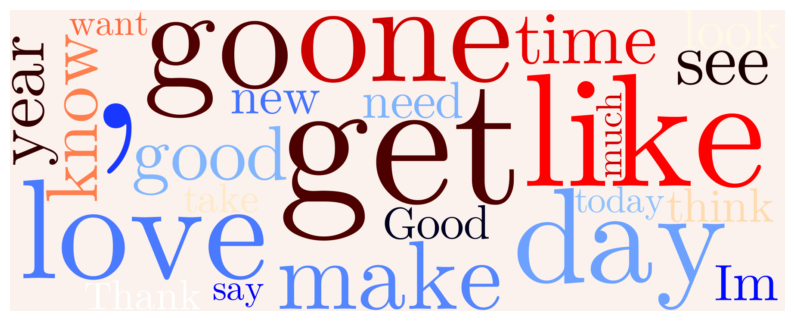

8 [('’', 734225), ('“', 254955), ('people', 211835), ('”', 194794), ('say', 169007), ('get', 151338), ('like', 142737), ('know', 131700), ('think', 130477), ('go', 128887), ('Trump', 113659), ('one', 113524), ('make', 108808), ('want', 106722), ('right', 99227), ('Putin', 97501), ('Biden', 94662), ('would', 94001), ('see', 81802), ('need', 80920), ('time', 79633), ('thing', 74820), ('us', 73651), ('take', 72866), ('dont', 67379)]


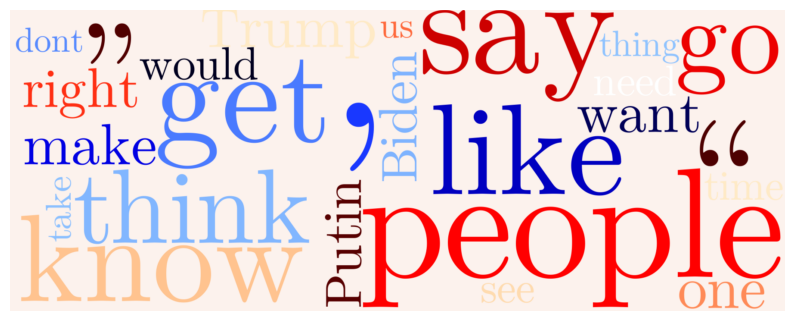

2 [('’', 292064), ('get', 110991), ('people', 105141), ('year', 90713), ('say', 87430), ('school', 80700), ('COVID19', 77969), ('“', 75925), ('new', 70170), ('test', 69471), ('COVID', 68654), ('work', 64874), ('mask', 60570), ('case', 60085), ('vaccine', 59205), ('make', 58640), ('go', 58501), ('need', 56754), ('one', 56689), ('child', 54113), ('”', 52540), ('US', 52190), ('health', 50661), ('state', 49328), ('take', 46939)]


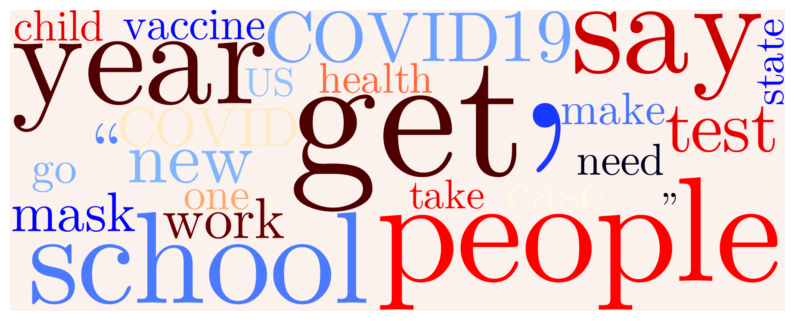

3 [('’', 332236), ('Trump', 207245), ('“', 114378), ('say', 109546), ('vote', 97510), ('House', 75625), ('Jan', 74325), ('Biden', 67970), ('Court', 67244), ('”', 67092), ('Senate', 62096), ('Supreme', 60542), ('election', 59505), ('right', 59197), ('President', 57593), ('BREAKING', 55684), ('US', 53242), ('Republican', 52051), ('get', 50360), ('GOP', 46700), ('year', 46078), ('call', 45911), ('January', 45818), ('Republicans', 45564), ('make', 44391)]


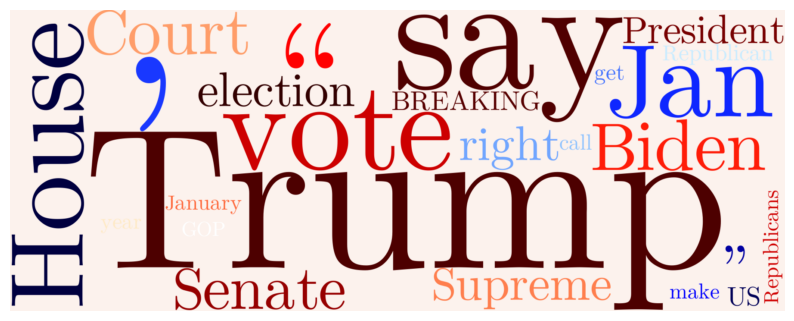

5 [('Ukraine', 242052), ('’', 223309), ('Russian', 204611), ('Russia', 171049), ('US', 115543), ('say', 102750), ('Putin', 83862), ('Ukrainian', 82367), ('“', 79761), ('war', 64886), ('Biden', 62609), ('President', 56836), ('”', 49828), ('Kyiv', 47704), ('people', 46716), ('military', 46513), ('BREAKING', 45753), ('force', 42494), ('oil', 37578), ('take', 37246), ('country', 36803), ('invasion', 36788), ('use', 36038), ('attack', 36017), ('new', 35736)]


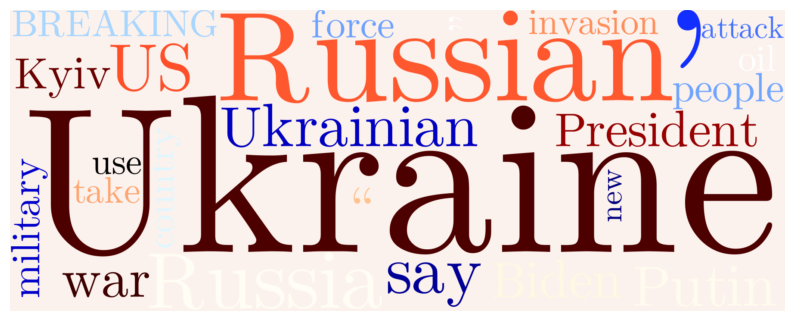

9 [('’', 180190), ('year', 51452), ('“', 48007), ('first', 38929), ('”', 38478), ('win', 36129), ('get', 34658), ('game', 33784), ('new', 33360), ('today', 32970), ('one', 31693), ('go', 31202), ('time', 27465), ('say', 27077), ('day', 26915), ('team', 26423), ('make', 25917), ('Happy', 24125), ('play', 23317), ('show', 22532), ('take', 22403), ('see', 22278), ('like', 21519), ('last', 21415), ('great', 20875)]


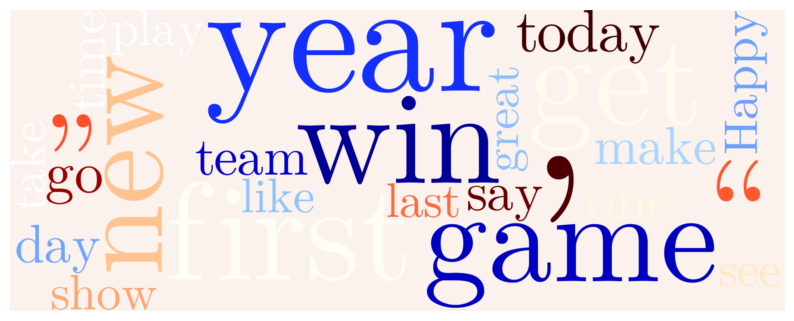

4 [('’', 67528), ('snow', 65334), ('tornado', 47801), ('storm', 45161), ('area', 43892), ('morning', 43156), ('today', 42107), ('weather', 40311), ('wind', 39753), ('fire', 39490), ('day', 35504), ('see', 34417), ('across', 34109), ('near', 33289), ('County', 30492), ('look', 29137), ('get', 27930), ('rain', 26266), ('winter', 25912), ('year', 24592), ('high', 24265), ('week', 23346), ('temperature', 23270), ('go', 22515), ('last', 22305)]


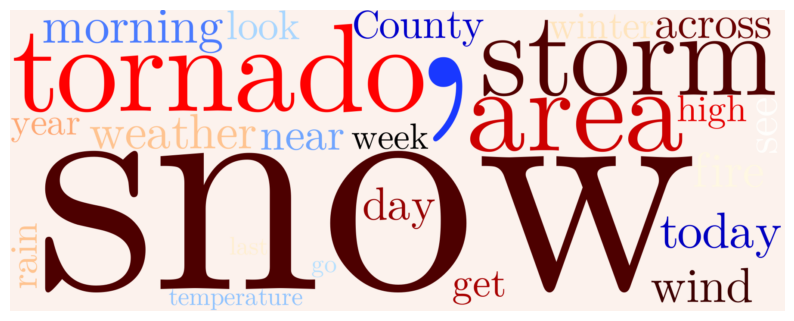

6 [('’', 78411), ('New', 51161), ('via', 50219), ('NowPlaying', 27483), ('‘', 25134), ('Listen', 21663), ('Learning', 21105), ('online', 21023), ('Machine', 20644), ('Day', 18770), ('artwork', 18754), ('sale', 17772), ('“', 16454), ('Warning', 15327), ('”', 14645), ('US', 14495), ('PM', 14049), ('News', 13228), ('Biden', 12801), ('issue', 12623), ('Trump', 12144), ('–', 10192), ('till', 10068), ('Ukraine', 9693), ('Jan', 9651)]


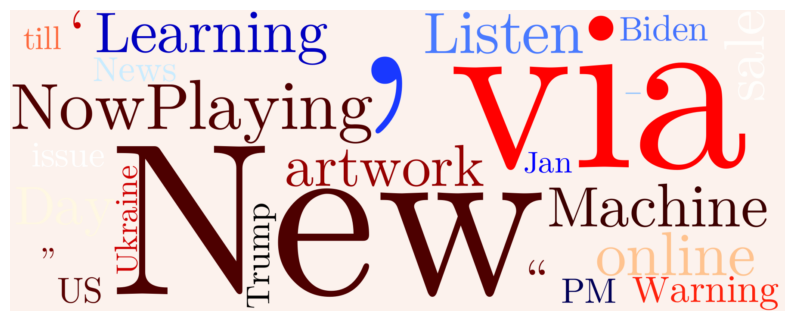

7 [('’', 31816), ('via', 30112), ('Check', 24964), ('book', 23183), ('new', 13106), ('love', 12290), ('“', 11757), ('…', 11694), ('”', 10084), ('shop', 9573), ('share', 9123), ('handmade', 9038), ('Vintage', 8659), ('New', 8552), ('read', 8495), ('gift', 8362), ('story', 7868), ('art', 7846), ('available', 7475), ('item', 7411), ('Christmas', 7354), ('etsy', 7226), ('Art', 7170), ('need', 7115), ('Hand', 6941)]


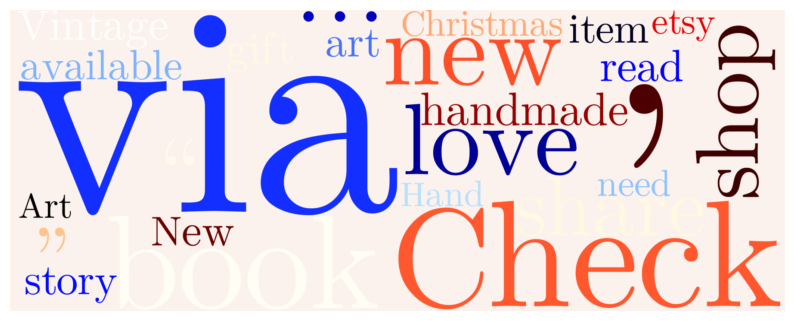

1 [('de', 70485), ('la', 34401), ('en', 24898), ('earthquake', 22186), ('que', 20516), ('el', 17519), ('km', 13988), ('un', 11917), ('magnitude', 10404), ('e', 9696), ('del', 9160), ('’', 8939), ('para', 8727), ('los', 8580), ('le', 8500), ('photography', 7696), ('con', 7639), ('se', 7531), ('por', 6545), ('La', 6408), ('una', 6107), ('nature', 6070), ('bear', 5965), ('UTC', 5544), ('NaturePhotography', 5315)]


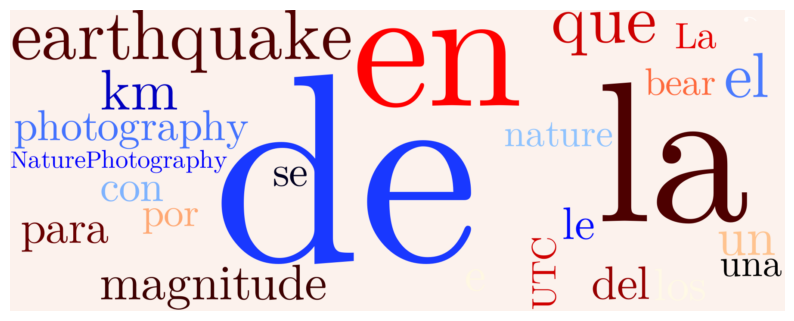

In [49]:
for cluster in top_index:
    draw_wordcloud(full_model, cluster, 25)

In [10]:
gsdmm2 = MovieGroupProcess(K=10, alpha=0.1, beta=0.3, n_iters=15)

In [11]:
gsdmm2.load("gsdmm_model")

In [12]:
gsdmm2.cluster_doc_count

[1111730,
 492994,
 300599,
 587051,
 342446,
 754712,
 192951,
 358657,
 226500,
 426645]

In [13]:
gsdmm2.cluster_word_distribution

[{'Todays': 285,
  'inspiration': 487,
  'Eliza': 15,
  'Todd': 227,
  'Brilliant': 262,
  'Thanks': 7351,
  'share': 8250,
  'Strange': 206,
  'coincidence': 306,
  'shady': 102,
  'humor': 702,
  'Trump': 7993,
  'Gets': 69,
  'Final': 62,
  'Okay': 1362,
  'Sell': 47,
  'DC': 891,
  'Hotel': 38,
  'Gosh': 211,
  '10K': 40,
  'follower': 3605,
  'achieve': 457,
  'Thank': 13971,
  'much': 24744,
  'Special': 92,
  'thanks': 2763,
  'everyone': 13090,
  'cringe': 226,
  'Told': 173,
  'Guy': 454,
  '…': 7189,
  'Four': 163,
  'Weeks': 6,
  'ago': 7505,
  'predict': 447,
  'doom': 398,
  'Ukraine': 4311,
  'say': 52208,
  'air…': 28,
  'Kitten': 39,
  'couldnt': 1957,
  'walk': 6760,
  'race': 1738,
  'big': 11179,
  'brother': 2661,
  'dinner': 1317,
  '❤️': 3963,
  'group': 2559,
  '‘': 7577,
  '’': 280067,
  'none': 1306,
  'succeed': 420,
  'strongly': 166,
  'advocate': 658,
  'try': 19653,
  'Even': 2878,
  'easy': 4320,
  'simulation': 57,
  'would': 32786,
  'tell': 22979,
  's

In [1]:
import pandas as pd
df = pd.read_csv("all_data_df_v1.csv")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_42293/1366739633.py:2: DtypeWarning: Columns (0,2,4,5,6,7,8,11,12,13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("all_data_df_v1.csv")


In [8]:
df["text"].to_csv("all_text_df_v1.csv" ,header=False, index=False)